In [5]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from tqdm.auto import tqdm, trange
from statsmodels.tsa.arima.model import ARIMAResults, ARIMA
import plotly.graph_objects as go

from windpred import predict, pretrain, update, trial, train_model
from data import read_erdc_file, find_sequences, plot_seqs, probabilistic_distance

from scipy.stats import boxcox
from scipy.special import inv_boxcox

pd.options.plotting.backend = "matplotlib"
READ_CSV=False

## Data extraction/pre-processing

In [2]:
df = read_erdc_file(processed=True)
df.describe()

,Speed,Direction,Temp,dx,dy
count,872200.000000,872200.000000,872200.000000,872200.000000,872200.000000
mean,5.985058,170.741241,74.877663,0.015585,0.008400
std,3.792214,111.159401,10.505797,0.707486,0.706506
min,-0.219700,-34.869999,49.970001,-1.000000,-1.000000
25%,3.037000,68.620003,65.489998,-0.673152,-0.715212
50%,5.311000,191.300003,78.620003,0.042393,0.011780
75%,8.265000,231.330002,82.849998,0.695693,0.741516
max,32.259998,396.589996,97.599998,1.000000,1.000000


In [3]:
df_all = df # original dataframe with all data
# Testing data
dft = df_all.loc['2022-06-28':'2022-07-07']
# Training data
df = df_all.loc['2022-03-10':'2022-06-27']
INTERVAL = pd.Timedelta(minutes=15)

In [4]:
# separate into contiguous sequences
seqs = find_sequences(df, INTERVAL)
seqsog = find_sequences(df_all, INTERVAL)
print(len(seqs), len(seqsog))

2 13


In [ ]:
plot_seqs(seqsog)
plt.axvline(seqs[0].index[0], color='r')
plt.axvline(seqs[-1].index[-1], color='r')

## Timeseries Analysis

In [ ]:
# Stationarity
from statsmodels.tsa.stattools import kpss

# Null hypothesis: process is stationary

def kpss_test(timeseries):
    # print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    return kpss_output

tests = [kpss_test(s.Speed) for s in seqs]
pd.concat(tests, axis=1)

In [ ]:
# Correlation
corrs = df.rolling(1).mean().corr()
fig = go.Figure()
fig.add_trace(
    go.Heatmap(
        x = corrs.columns,
        y = corrs.index,
        z = corrs,
        text=corrs.values,
        texttemplate='%{text:.2f}'
    )
)
fig.update_layout(height=300, width=300)
fig.show()

In [ ]:
# Filtering
from statsmodels.tsa.filters import hp_filter, bk_filter
seq = seqs[0]
plt.plot(seq.Speed)
cycle = bk_filter.bkfilter(seq.Speed, low=1e1, high=1e2, K=10)
plt.plot(seq.Speed.mean()+cycle)

In [ ]:
# Autocorrelation, used to select order of Moving Average (MA) in ARIMA models
plt.figure(figsize=(8,4))
ax = plt.subplot(1,1,1)
for s in seqsog:
    sm.graphics.tsa.plot_acf(s.Speed, lags=min(100, len(s)-1), ax=ax)
plt.xlabel(f'Time interval {s.index.freq}')
plt.tight_layout()

In [ ]:
# Partial Autocorrelation, used to select order of Autoregression (AR) in ARIMAX models
plt.figure(figsize=(8,4))
ax = plt.subplot(1,1,1)
for s in seqsog:
    sm.graphics.tsa.plot_pacf(s.Speed, lags=min(100, len(s)//2-1), ax=ax)
plt.xlabel(f'Time interval {s.index.freq}')
plt.tight_layout()

## ARIMA models

In [94]:
model = sm.tsa.ARIMA(seqs[0].Speed.iloc[:-100], order=(1,0,20))
result = model.fit()
actual = seqs[0].Speed.iloc[-100:]
_, predictions = predict(result, actual, None, INTERVAL)


/home/ibrah/Developer/wind-pred/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ibrah/Developer/wind-pred/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<Axes: xlabel='lag'>

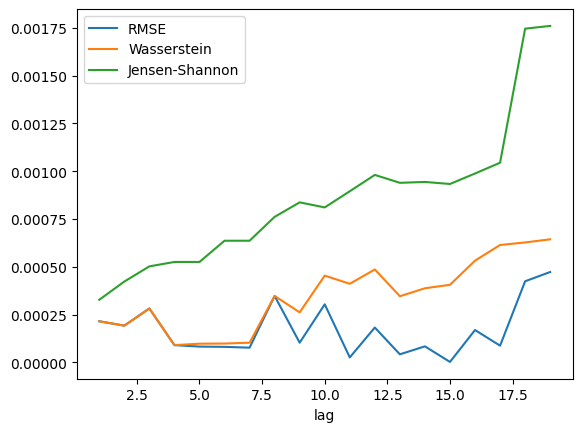

In [100]:
df = pd.DataFrame({'lag':[], 'RMSE':[], 'Wasserstein':[], 'Jensen-Shannon':[]})
df.set_index(['lag'], inplace=True)
df

arr = np.random.randn(10000)
for lag in range(1,20):
    a = arr[lag:]
    b = arr[:len(arr)-lag]
    df.loc[lag] = [np.sqrt(np.mean(a-b)**2),
                   probabilistic_distance(a, b, measure='wasserstein'),
                   probabilistic_distance(a, b, measure='jensenshannon')]
df.plot()

In [99]:
df.head()

,RMSE,Wasserstein,Jensen-Shannon
lag,,,
1,0.000067,0.000067,NaN
2,0.000142,0.000142,NaN
3,0.000324,0.000324,NaN
4,0.000248,0.000303,NaN
5,0.000204,0.000348,NaN


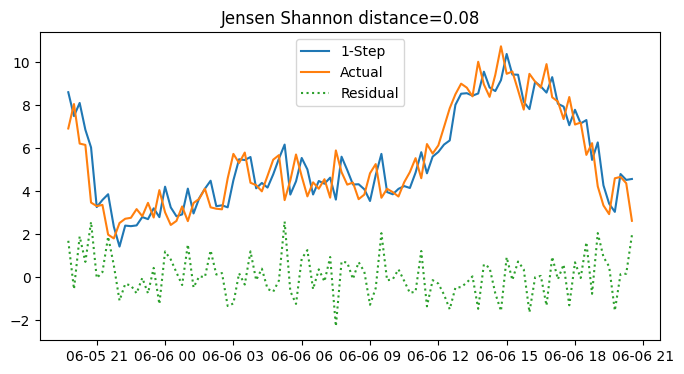

In [97]:

plt.figure(figsize=(8,4))
plt.plot(predictions, label='1-Step')
# plt.plot(predictions_recursive, label='Recursive')
plt.plot(seqs[0].Speed.iloc[-100:], label='Actual')
plt.plot(predictions - actual, label='Residual', ls=':')
# plt.title('RMSE=%.2f' % sm.tools.eval_measures.rmse(predictions, actual))
plt.title('Jensen Shannon distance=%.2f' % probabilistic_distance(predictions, actual, measure='jensenshannon'))
# plt.title('RMSE=%.2f' % np.sqrt(np.mean((predictions - actual)**2)))
plt.legend()

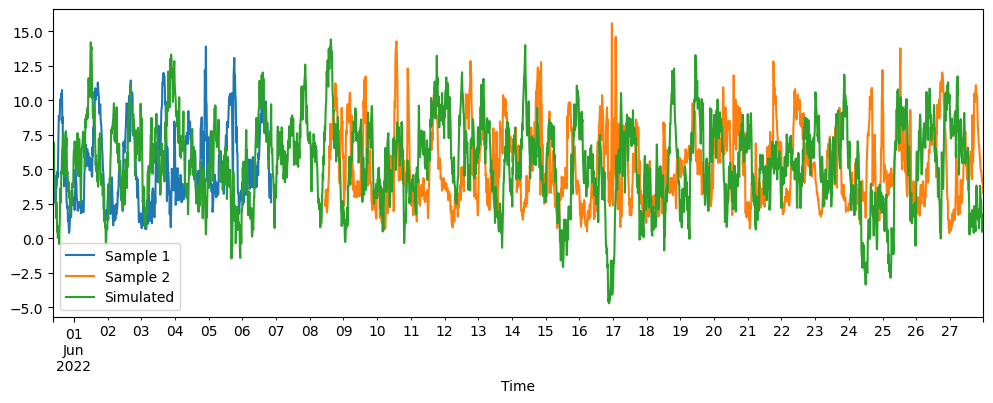

In [67]:
plt.figure(figsize=(12,4))
sim = result.simulate(int((seqs[1].index[-1] - seqs[0].index[0]) / seqs[0].index.freq))
seqs[0].Speed.plot(label='Sample 1')
seqs[1].Speed.plot(label='Sample 2')
sim.plot(label='Simulated')
plt.legend()

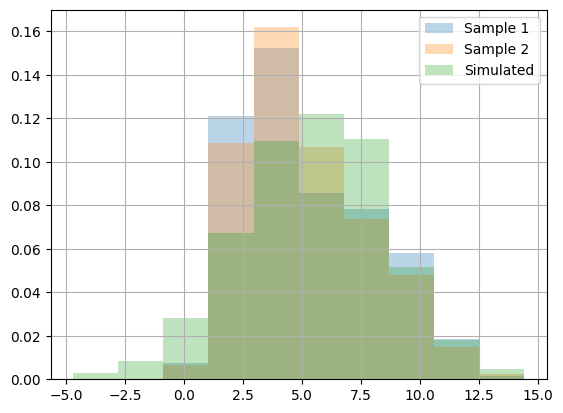

In [68]:
_, bins = np.histogram(sim)
seqs[0].Speed.hist(bins=bins, density=True, alpha=0.3, label='Sample 1')
seqs[1].Speed.hist(bins=bins, density=True, alpha=0.3, label='Sample 2')
sim.hist(bins=bins, density=True, alpha=0.3, label='Simulated')
plt.legend()

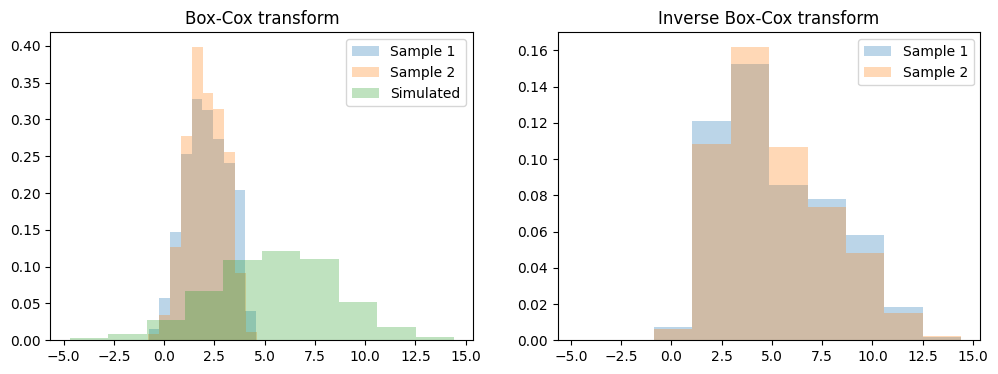

In [71]:
s0 = seqs[0].Speed
s1 = seqs[1].Speed
# bsim, lmbdasim = boxcox(sim)
b0, lmbda0 = boxcox(s0)
b1, lmbda1 = boxcox(s1)

fig, ax = plt.subplots(1,2, figsize=(12,4))

ax[0].hist(b0, bins=10, density=True, alpha=0.3, label='Sample 1')
ax[0].hist(b1, bins=10, density=True, alpha=0.3, label='Sample 2')
ax[0].hist(sim, bins=10, density=True, alpha=0.3, label='Simulated')
ax[0].set_title('Box-Cox transform')
ax[0].legend()

_, bins = np.histogram(sim)
ax[1].hist(inv_boxcox(b0, lmbda0), bins=bins, density=True, alpha=0.3, label='Sample 1')
ax[1].hist(inv_boxcox(b1, lmbda1), bins=bins, density=True, alpha=0.3, label='Sample 2')
ax[1].set_title('Inverse Box-Cox transform')
ax[1].legend()


In [75]:
s0 = pd.Series(b0, index=seqs[0].index)
s1 = pd.Series(b1, index=seqs[1].index)

In [77]:
model = sm.tsa.ARIMA(s0.iloc[:-100], order=(1,0,20))
result = model.fit()
actual = s0.iloc[-100:]
_, predictions = predict(result, actual, None, INTERVAL)


/home/ibrah/Developer/wind-pred/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ibrah/Developer/wind-pred/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


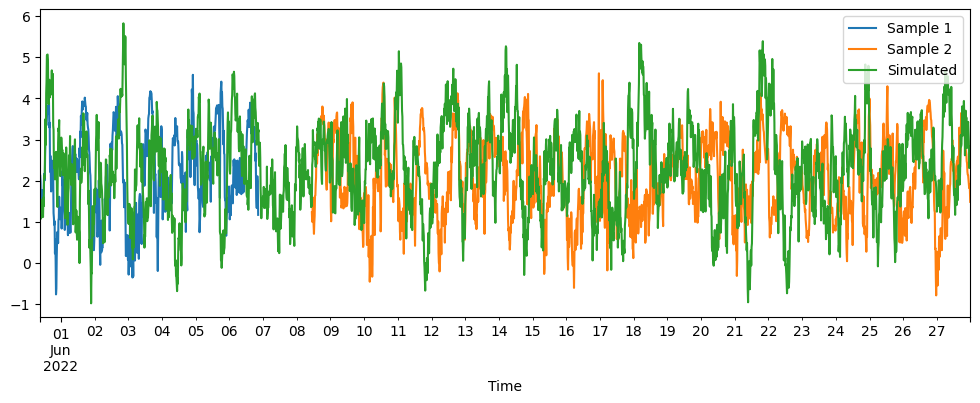

In [80]:
plt.figure(figsize=(12,4))
sim = result.simulate(int((seqs[1].index[-1] - seqs[0].index[0]) / seqs[0].index.freq))
# sim_inv = in
s0.plot(label='Sample 1')
s1.plot(label='Sample 2')
sim.plot(label='Simulated')
plt.legend()

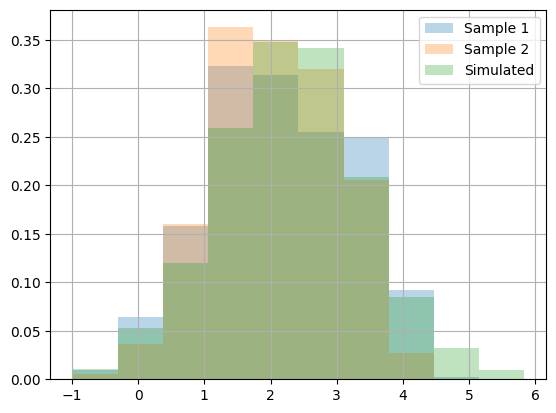

In [81]:
_, bins = np.histogram(sim)
s0.hist(bins=bins, density=True, alpha=0.3, label='Sample 1')
s1.hist(bins=bins, density=True, alpha=0.3, label='Sample 2')
sim.hist(bins=bins, density=True, alpha=0.3, label='Simulated')
plt.legend()

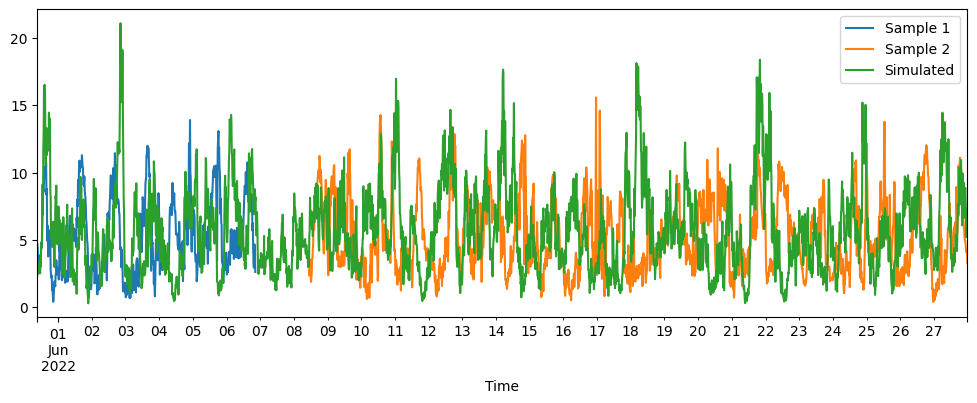

In [85]:
sim_inv = inv_boxcox(sim, lmbda0)
sim_inv = pd.Series(sim_inv, index=sim.index)
plt.figure(figsize=(12,4))
seqs[0].Speed.plot(label='Sample 1')
seqs[1].Speed.plot(label='Sample 2')
sim_inv.plot(label='Simulated')
plt.legend()

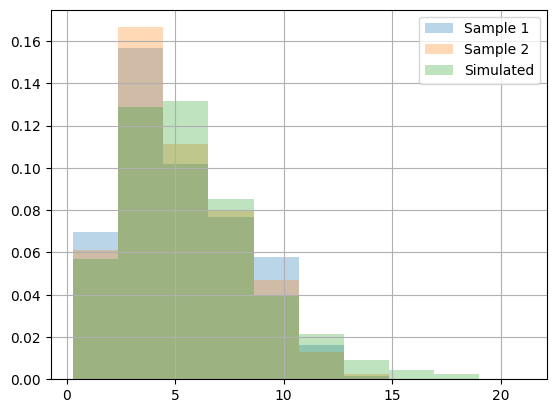

In [84]:
_, bins = np.histogram(sim_inv)
seqs[0].Speed.hist(bins=bins, density=True, alpha=0.3, label='Sample 1')
seqs[1].Speed.hist(bins=bins, density=True, alpha=0.3, label='Sample 2')
sim_inv.hist(bins=bins, density=True, alpha=0.3, label='Simulated')
plt.legend()

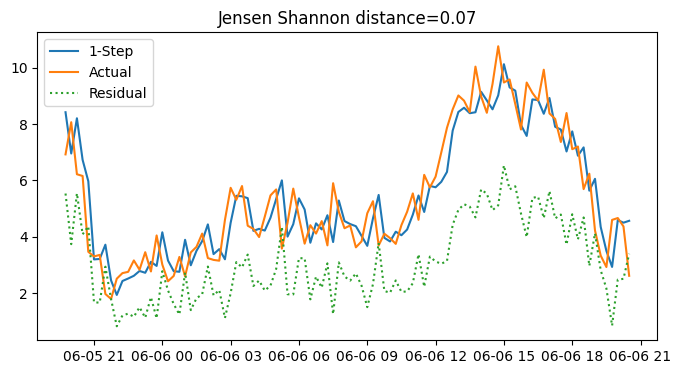

In [93]:
pred_inv = inv_boxcox(predictions, lmbda0)
pred_inv = pd.Series(pred_inv, index=predictions.index)
plt.figure(figsize=(8,4))
plt.plot(pred_inv, label='1-Step')
# plt.plot(predictions_recursive, label='Recursive')
plt.plot(seqs[0].Speed.iloc[-100:], label='Actual')
plt.plot(pred_inv - actual, label='Residual', ls=':')
# plt.title('RMSE=%.2f' % sm.tools.eval_measures.rmse(predictions, seqs[0].Speed.iloc[-100:]))
plt.title('Jensen Shannon distance=%.2f' % probabilistic_distance(pred_inv, seqs[0].Speed.iloc[-100:], measure='jensenshannon'))
# plt.title('RMSE=%.2f' % np.sqrt(np.mean((pred_inv - seqs[0].Speed.iloc[-100:])**2)))
plt.legend()

In [21]:
def synthesize_data(seq: pd.Series, size=24*15*365):
    b, lmbda = boxcox(seq)
    b = pd.Series(b, index=seq.index)
    model=sm.tsa.ARIMA(b, order=(1,0,20))
    result = model.fit()
    sim = result.simulate(size)
    sim_inv = inv_boxcox(sim, lmbda)
    pred_inv = pd.Series(sim_inv, index=sim.index)
    return sim_inv


In [22]:
d = synthesize_data(seqs[0].Speed)
d.to_csv('synthetic.csv')

/home/ibrah/Developer/wind-pred/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ibrah/Developer/wind-pred/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ibrah/Developer/wind-pred/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Axes: >

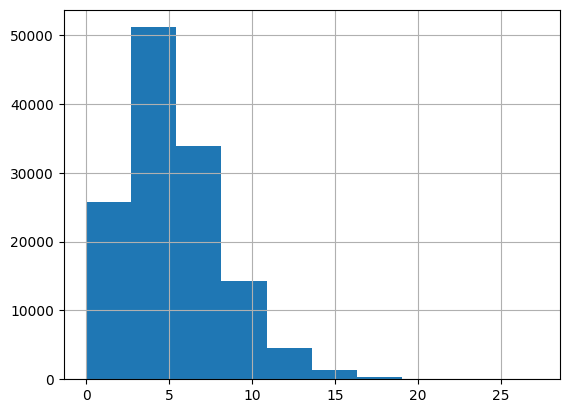

In [20]:
d.hist()

In [ ]:
seqstrain = find_sequences(df, INTERVAL)
seqstest = find_sequences(dft, INTERVAL)
order = (1, 0, 20)
res = pretrain(ARIMA, seqstrain[0].Speed, exog=None, order=order)
for s in tqdm(seqstrain[1:], leave=False):
    res = update(res, s.Speed, None, INTERVAL)
n = 0
abserr = 0
for s in tqdm(seqstest, leave=False):
    res, pred = predict(res, s.Speed, None, INTERVAL)
    abserr += np.abs(np.sum(((s.Speed - pred) / s.Speed)))
    n += len(s)
mape = abserr * 100 / n
print('MAPE %.2f' % mape)

In [ ]:
seqstrain = find_sequences(df, INTERVAL)
seqstest = find_sequences(dft, INTERVAL)
order = (1, 0, 20)
res = pretrain(ARIMA, seqstrain[0].dx, exog=None, order=order)
for s in tqdm(seqstrain[1:], leave=False):
    res = update(res, s.dx, None, INTERVAL)
dxs, dx_actual = [], []
for s in tqdm(seqstest, leave=False):
    res, pred = predict(res, s.dx, None, INTERVAL)
    dx_actual.extend(s.dx)
    dxs.extend(pred)

res = pretrain(ARIMA, seqstrain[0].dy, exog=None, order=order)
for s in tqdm(seqstrain[1:], leave=False):
    res = update(res, s.dy, None, INTERVAL)
dys, dy_actual = [], []
for s in tqdm(seqstest, leave=False):
    res, pred = predict(res, s.dy, None, INTERVAL)
    dy_actual.extend(s.dy)
    dys.extend(pred)

dxs = np.asarray(dxs)
dys = np.asarray(dys)
dx_actual = np.asarray(dx_actual)
dy_actual = np.asarray(dy_actual)

heading = np.arctan2(dys, dxs)
heading_actual = np.arctan2(dy_actual, dx_actual)

mape = np.mean(np.abs((heading_actual - heading)/heading_actual)) * 100

print('MAPE %.2f' % mape)

## LSTM

In [95]:
import torch
import torch.nn as nn

from lstm import Model, train_lstm

In [104]:
model = Model()

In [106]:
train_lstm(model, data=seqs[0].Speed)

/home/ibrah/Developer/wind-pred/.venv/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 0, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan

In [105]:
model(torch.randn(10,5)).shape

torch.Size([10, 5, 10])


torch.Size([10, 5])